# TODO DOCUMENTAT

# Install

In [1]:
# !pip install -q "monai-weekly[nibabel, skimage, scipy, pillow, tensorboard, gdown, ignite, torchvision, itk, tqdm, lmdb, psutil, cucim, openslide, pandas, einops, transformers, mlflow, clearml, matplotlib, tensorboardX, tifffile, imagecodecs, pyyaml, fire, jsonschema, ninja, pynrrd, pydicom, h5py, nni, optuna, onnx, onnxruntime, zarr, lpips, pynvml, huggingface_hub]"

# Import libraries

In [2]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings

import monai
# monai.config.print_config()

from monai.apps import DecathlonDataset
from monai.data import DataLoader, CacheDataset
from monai.utils import first, set_determinism
from monai.networks.nets import UNet, DynUNet, AttentionUnet, ViTAutoEnc, UNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric, MeanIoU, compute_average_surface_distance
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    LoadImage,
    LoadImageD,
    EnsureChannelFirstD,
#     AddChannelD,
    ScaleIntensityD,
    ToTensorD,
    Compose,
    AsDiscreteD,
    SpacingD,
    OrientationD,
    ResizeD,
    RandAffineD,
    AsDiscrete,
    AsDiscreted,
    EnsureTyped,
    EnsureType,
    LoadImageD,
    EnsureChannelFirstD,
    OrientationD,
    SpacingD,
    ScaleIntensityD,
    ResizeD,
    RandAffineD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
#     RandDeformD,
    ToTensorD,
)

import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

In [3]:
cuda = torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")
# device = "cpu"
num_workers = 4 if cuda else 1


print(f'You are using {device}')

You are using cuda


#### Set seeds

In [4]:
import sys
from tqdm import tqdm
import pandas as pd
import pickle as pkl

In [5]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### Hyperparameters

In [6]:
BATCH_SIZE = 1

IMG_HEIGHT = 128
IMG_WIDTH = 128
COLOUR_CHANNELS = 1
# NO_STACKED_IMGS = 64

In [7]:
print(f'Running device: {torch.cuda.get_device_name(0)}')
print(f'Number of devices used: {torch.cuda.device_count()}')

Running device: Tesla V100-DGXS-32GB
Number of devices used: 4


In [8]:
crt_dir = os.getcwd()

datasets_path = f'{crt_dir}/datasets/MedicalDecathlon/'

# Visualize data

## TRAIN

In [9]:
# Set up transform
KEYS = ["image", "label"]

base_transform = Compose([
    LoadImageD(keys=KEYS),
])


# transform = Compose([
#     LoadImageD(keys = KEYS),
#     EnsureChannelFirstD(keys = KEYS),
#     OrientationD(KEYS, axcodes='RAS'),
#     SpacingD(keys = KEYS,
#              pixdim = (1., 1., 1.),
#              mode = ('bilinear', 'nearest')),
#     ScaleIntensityD(keys = "image"),
#     ResizeD(KEYS,
#             (128, 128, 64),
#             mode=('trilinear', 'nearest')),
#     RandAffineD(keys = KEYS,
#                 spatial_size = (128, 128, 64),
#                 rotate_range = (0, 0, np.pi/12),
#                 scale_range = (0.1, 0.1, 0.1),
#                 mode = ('bilinear', 'nearest'),
#                 prob = 1.0),
#     ToTensorD(KEYS),
# ])


train_transform = Compose([
    LoadImageD(keys=KEYS),
    # EnsureChannelFirstD(keys=KEYS),
    # OrientationD(keys=KEYS, axcodes='RAS'),
    # SpacingD(keys=KEYS, pixdim=(1., 1., 1.), mode=('bilinear', 'nearest')),
    # ScaleIntensityD(keys="image"),
    # ResizeD(keys=KEYS, spatial_size=(IMG_HEIGHT, IMG_HEIGHT, NO_STACKED_IMGS), mode=('trilinear', 'nearest')),
    # # ResizeD(keys=KEYS, spatial_size=(128, 128, 64), mode=('trilinear', 'nearest')),

    # RandAffineD(
    #     keys=KEYS,
    #     spatial_size= (IMG_HEIGHT, IMG_HEIGHT, NO_STACKED_IMGS),

    #     # spatial_size=(128, 128, 64),
    #     rotate_range=(0, 0, np.pi/12),
    #     scale_range=(0.1, 0.1, 0.1),
    #     mode=('bilinear', 'nearest'),
    #     prob=0.5
    # ),
    # RandFlipD(keys=KEYS, spatial_axis=[0,1], prob=0.5),
    # RandRotateD(keys=KEYS, range_x=np.pi/12, range_y=np.pi/12, range_z=np.pi/12, prob=0.5),
    # RandZoomD(keys=KEYS, min_zoom=0.9, max_zoom=1.1, prob=0.5),
    # ToTensorD(keys=KEYS),
])

In [10]:
# Load data
train_name = 'training' # From Monai: ['training', 'validation', 'test']
train_dataset = DecathlonDataset(root_dir = f'{datasets_path}{train_name}/',
                           task = "Task06_Lung", section = train_name,
                           transform = base_transform, download = False)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = False) #, num_workers = 1)

Loading dataset: 100%|██████████| 51/51 [03:29<00:00,  4.11s/it]


In [11]:
name_stacks_pkl = f'{crt_dir}/{train_name}_stacks.pkl'

In [12]:
patients = {patient: [] for patient in range(len(train_dataset))}

for i, data in enumerate(tqdm(train_loader)):
    label = data['label'][0]
    print(label.shape)

    for j in range(label.shape[-1]):
        if (label[:, :, j].sum() != 0):
            patients[i].append(j)

with open(name_stacks_pkl, 'wb') as f:
    pkl.dump(patients, f)

  0%|          | 0/51 [00:00<?, ?it/s]

torch.Size([512, 512, 589])


  4%|▍         | 2/51 [00:00<00:12,  3.96it/s]

torch.Size([512, 512, 267])
torch.Size([512, 512, 227])


  8%|▊         | 4/51 [00:00<00:09,  4.92it/s]

torch.Size([512, 512, 450])


 10%|▉         | 5/51 [00:01<00:08,  5.42it/s]

torch.Size([512, 512, 277])
torch.Size([512, 512, 260])


 16%|█▌        | 8/51 [00:01<00:05,  7.24it/s]

torch.Size([512, 512, 125])
torch.Size([512, 512, 273])


 18%|█▊        | 9/51 [00:01<00:05,  7.38it/s]

torch.Size([512, 512, 251])
torch.Size([512, 512, 636])


 22%|██▏       | 11/51 [00:02<00:07,  5.50it/s]

torch.Size([512, 512, 301])
torch.Size([512, 512, 304])


 27%|██▋       | 14/51 [00:02<00:05,  7.09it/s]

torch.Size([512, 512, 115])
torch.Size([512, 512, 241])


 29%|██▉       | 15/51 [00:02<00:05,  7.17it/s]

torch.Size([512, 512, 249])
torch.Size([512, 512, 289])


 33%|███▎      | 17/51 [00:02<00:04,  6.87it/s]

torch.Size([512, 512, 282])
torch.Size([512, 512, 291])


 37%|███▋      | 19/51 [00:03<00:04,  6.69it/s]

torch.Size([512, 512, 276])
torch.Size([512, 512, 296])


 39%|███▉      | 20/51 [00:03<00:04,  6.53it/s]

torch.Size([512, 512, 567])


 43%|████▎     | 22/51 [00:03<00:06,  4.65it/s]

torch.Size([512, 512, 423])


 45%|████▌     | 23/51 [00:03<00:05,  5.15it/s]

torch.Size([512, 512, 242])
torch.Size([512, 512, 243])


 49%|████▉     | 25/51 [00:04<00:04,  6.05it/s]

torch.Size([512, 512, 251])
torch.Size([512, 512, 155])


 53%|█████▎    | 27/51 [00:04<00:03,  7.06it/s]

torch.Size([512, 512, 241])
torch.Size([512, 512, 304])


 57%|█████▋    | 29/51 [00:04<00:03,  7.01it/s]

torch.Size([512, 512, 228])
torch.Size([512, 512, 322])


 61%|██████    | 31/51 [00:05<00:03,  6.43it/s]

torch.Size([512, 512, 226])
torch.Size([512, 512, 256])


 63%|██████▎   | 32/51 [00:05<00:03,  5.31it/s]

torch.Size([512, 512, 531])


 65%|██████▍   | 33/51 [00:05<00:04,  4.38it/s]

torch.Size([512, 512, 483])


 69%|██████▊   | 35/51 [00:06<00:03,  4.17it/s]

torch.Size([512, 512, 314])
torch.Size([512, 512, 241])


 75%|███████▍  | 38/51 [00:06<00:02,  5.97it/s]

torch.Size([512, 512, 211])
torch.Size([512, 512, 128])


 76%|███████▋  | 39/51 [00:06<00:01,  6.58it/s]

torch.Size([512, 512, 218])
torch.Size([512, 512, 248])


 80%|████████  | 41/51 [00:07<00:01,  6.91it/s]

torch.Size([512, 512, 241])
torch.Size([512, 512, 271])


 84%|████████▍ | 43/51 [00:07<00:01,  6.77it/s]

torch.Size([512, 512, 251])
torch.Size([512, 512, 241])


 88%|████████▊ | 45/51 [00:07<00:00,  6.39it/s]

torch.Size([512, 512, 329])
torch.Size([512, 512, 228])


 92%|█████████▏| 47/51 [00:07<00:00,  6.80it/s]

torch.Size([512, 512, 242])
torch.Size([512, 512, 252])


 96%|█████████▌| 49/51 [00:08<00:00,  6.42it/s]

torch.Size([512, 512, 266])
torch.Size([512, 512, 126])


100%|██████████| 51/51 [00:08<00:00,  6.04it/s]

torch.Size([512, 512, 125])


In [13]:
patients = pkl.load(open(name_stacks_pkl, 'rb'))

In [14]:
from copy import deepcopy

custom_dataset = deepcopy(train_dataset)

for i in range(len(custom_dataset)):
    custom_dataset[i]['label'] = custom_dataset[i]['label'][:, :, patients[i]]

train_loader = DataLoader(custom_dataset, batch_size = BATCH_SIZE, shuffle = False) #, num_workers = 1)

In [15]:
def get_EDA_params(dataset, crt_loader):
    print("Getting EDA parameters...")
    NO_PATIENTS = len(dataset)
    print(f'Number of patients: {NO_PATIENTS}')

    NO_STACKS = -1
    IMG_HEIGHT = -1
    IMG_WIDTH = -1
    for patient_batch in tqdm(crt_loader):
        # print(patient_batch['image'].shape)
        NO_STACKS = max(NO_STACKS, patient_batch['image'].shape[-1])
        IMG_HEIGHT = patient_batch['image'].shape[1]
        IMG_WIDTH = patient_batch['image'].shape[2]
        # break

    print(f'Number of max-stacks: {NO_STACKS}')
    print(f'Image height: {IMG_HEIGHT}')
    print(f'Image width: {IMG_WIDTH}')

    return NO_PATIENTS, NO_STACKS, IMG_HEIGHT, IMG_WIDTH


In [16]:
NO_PATIENTS_TR, NO_STACKS_TR, IMG_HEIGHT_TR, IMG_WIDTH_TR = get_EDA_params(custom_dataset, train_loader)

Getting EDA parameters...
Number of patients: 51


100%|██████████| 51/51 [00:01<00:00, 32.01it/s]

Number of max-stacks: 636
Image height: 512
Image width: 512


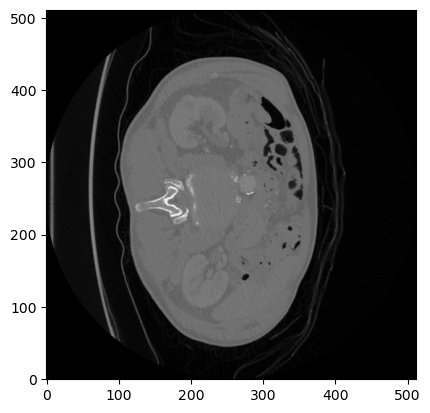

In [41]:
a = custom_dataset[0]['image']
plt.imshow(a[:, :, 0], cmap='gray')
plt.gca().invert_yaxis()

In [18]:
def show_slices(crt_loader, print_slices_flag =False):
    if print_slices_flag:
        for patient_batch in tqdm(crt_loader):
            img = patient_batch['image'][0].numpy()
            label = patient_batch['label'][0].numpy()

            plt.imshow(img[:, :, 0], cmap='gray')
            plt.imshow(label[:, :, 0], cmap='jet', alpha=0.5)
            plt.show()

In [19]:
print_slices_flag = False
show_slices(train_loader, print_slices_flag = print_slices_flag)

In [20]:
def instantiate_quantitative_counters(NO_PATIENTS, NO_STACKS, IMG_HEIGHT, IMG_WIDTH):
    
    # Splits the stacks into percentage bins and counts the number of tumor slices in each bin
    binning_volume = np.zeros((NO_PATIENTS, 10))

    # Splits stacks one by one to MAX_SLICES slices and counts the number of tumor slices in each patient
    stacks_full_volume = np.zeros((NO_PATIENTS, NO_STACKS))


    # Splits the 2D images into 16x16 patches and counts the number of tumor patches in each patch
    patches_height = IMG_HEIGHT // 16
    patches_width = IMG_WIDTH // 16
    zoomed_bins_2d = np.zeros((NO_PATIENTS, patches_height, patches_width))
    bins_2d = np.zeros((NO_PATIENTS, IMG_HEIGHT, IMG_WIDTH))

    # Counts the number of tumor voxels in each patient
    tumor_volume = np.zeros((NO_PATIENTS, 2)) # On first column tumor volume, on second column total volume
    slices_per_patient = np.zeros(NO_PATIENTS)

    return binning_volume, stacks_full_volume, bins_2d, zoomed_bins_2d, patches_height, patches_width, tumor_volume, slices_per_patient


def update_quantitative_counters(dataset, crt_loader):
    NO_PATIENTS, NO_STACKS, IMG_HEIGHT, IMG_WIDTH = get_EDA_params(dataset, crt_loader)

    binning_volume, stacks_full_volume, bins_2d, zoomed_bins_2d, patches_height, patches_width, tumor_volume, slices_per_patient = instantiate_quantitative_counters(NO_PATIENTS, NO_STACKS, IMG_HEIGHT, IMG_WIDTH)

    print(f"zoomed 2D bins shape: {zoomed_bins_2d.shape} (NO_PATIENTS, NO_PATCHES_HEIGHT, NO_PATCHES_WIDTH)")
    print(f"2D bins shape: {bins_2d.shape} (NO_PATIENTS, IMG_HEIGHT, IMG_WIDTH)")

    print(f"Depth bins shape: {binning_volume.shape} (NO_PATIENTS, PERCENTAGE_BINS)")

    i = 0
    for patient_batch in tqdm(crt_loader):
        label = patient_batch["label"][0].numpy()
        # print(label.shape)

        slices_per_patient[i] = label.shape[-1]

        crt_bin = zoomed_bins_2d[i]

        for j in range(label.shape[-1]):
            crt_stack = label[:, :, j]

            if np.sum(crt_stack) != 0:
                idx = int(((j * 10) / label.shape[-1]))
                binning_volume[i, idx] += 1
                stacks_full_volume[i, j] += 1

            for x in range(patches_height):
                for y in range(patches_width):
                    margins_height = (x+1)*16 if (x+1)*16 < IMG_HEIGHT else IMG_HEIGHT
                    margins_width = (y+1)*16 if (y+1)*16 < IMG_WIDTH else IMG_WIDTH

                    if np.sum(crt_stack[x*16:margins_height, y*16:margins_width]) != 0:
                        crt_bin[x, y] += 1

            for x in range(IMG_HEIGHT):
                for y in range(IMG_WIDTH):
                    if crt_stack[x, y] != 0:
                        bins_2d[i, x, y] += 1


        tumor_volume[i] = np.array([np.count_nonzero(label), IMG_HEIGHT*IMG_WIDTH*label.shape[-1]])
                
        i += 1


    return binning_volume, stacks_full_volume, bins_2d, zoomed_bins_2d, tumor_volume, slices_per_patient

In [21]:
binning_volume_tr, stacks_full_volume_tr, bins_2d_tr, zoomed_bins_2d_tr, tumor_volume_tr, slices_per_patient_tr = update_quantitative_counters(train_dataset, train_loader)

Getting EDA parameters...
Number of patients: 51


100%|██████████| 51/51 [00:01<00:00, 32.12it/s]


Number of max-stacks: 636
Image height: 512
Image width: 512
zoomed 2D bins shape: (51, 32, 32) (NO_PATIENTS, NO_PATCHES_HEIGHT, NO_PATCHES_WIDTH)
2D bins shape: (51, 512, 512) (NO_PATIENTS, IMG_HEIGHT, IMG_WIDTH)
Depth bins shape: (51, 10) (NO_PATIENTS, PERCENTAGE_BINS)


100%|██████████| 51/51 [12:51<00:00, 15.12s/it]


In [45]:
def plots_slices_per_patient_split(slices_per_patient, name, verbose_flag = False):
    NO_PATIENTS = len(slices_per_patient)
    mean_slices = np.mean(slices_per_patient)
    std_slices = np.std(slices_per_patient)

    print(f'Mean number of slices: {mean_slices}')
    print(f'Std for the number of slices: {std_slices}')

    fig, ax = plt.subplots(1,2, figsize=(15, 5))

    # Slices
    ax[0].bar(range(NO_PATIENTS), slices_per_patient)

    if verbose_flag:
        for i in range(NO_PATIENTS):
            ax[0].text(i, slices_per_patient[i], f'{slices_per_patient[i]}', ha='center')

    # Add the mean as a red line, starting from 0 to NO_PATIENTS
    ax[0].axhline(mean_slices, color='red', label='Mean')

    # Add variance as a yellow faded area
    ax[0].fill_between(np.arange(-0.5, NO_PATIENTS+0.5), mean_slices - std_slices, mean_slices + std_slices, color='yellow', alpha=0.5, label='Variance')

    ax[0].set_xlim(-1, NO_PATIENTS)
    ax[0].set_xlabel('Patient')
    ax[0].set_ylabel('Number of slices in CT')
    ax[0].set_title(f'{name.capitalize()}: Number of slices in CT for each patient')
    ax[0].legend()


    # # Slices
    plt.hist(slices_per_patient, bins=10)

    # Add the mean as a red line
    ax[1].set_xlabel('Number of slices in CT')
    ax[1].set_ylabel('Frequency of slices in CT')
    ax[1].set_title(f'{train_name.capitalize()}: Number of slices in CT for each patient - Histogram')
    fig.show()
    plt.show()


Mean number of slices: 26.84313725490196
Std for the number of slices: 19.18268474638522


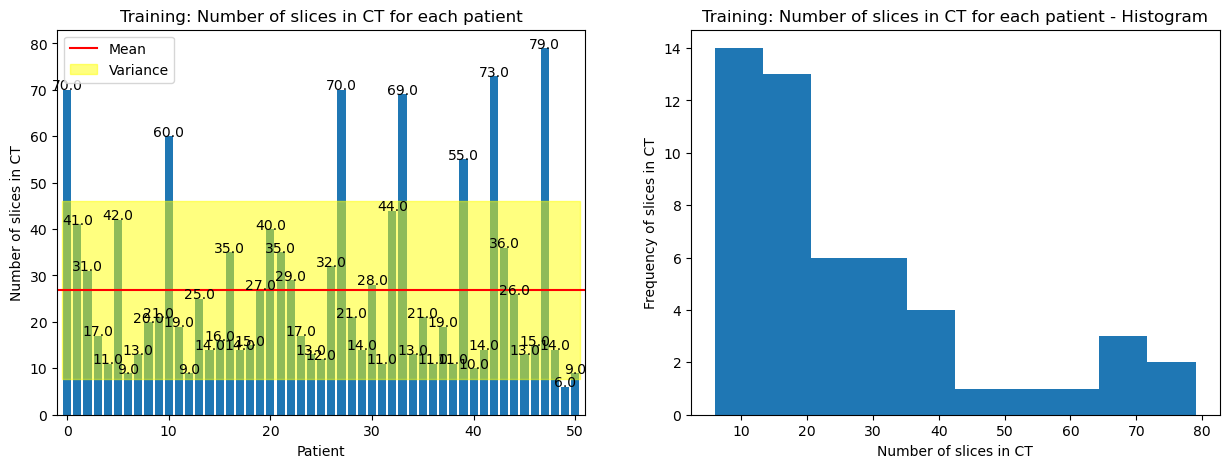

In [46]:
plots_slices_per_patient_split(slices_per_patient_tr, train_name, verbose_flag = True)

In [24]:
def plot_patients_heatmaps(bins_2d, name, print_slices_flag = False):
    NO_PATIENTS = len(bins_2d)
    #  Create heatmap for each patient
    if print_slices_flag:
        for i in range(NO_PATIENTS):
            plt.title(f'{name.capitalize()}: Patient {i}')
            plt.imshow(bins_2d[i], cmap='hot')
            plt.gca().invert_yaxis()
            plt.show()

In [25]:
plot_patients_heatmaps(bins_2d_tr, train_name, print_slices_flag = False)

In [26]:
def plot_aggregative_heatmaps(bins, binning_volume, name):
    NO_PATIENTS = len(bins)
    fig, ax = plt.subplots(1,2, figsize=(20, 5))

    ax[0].set_title(f'{train_name.capitalize()}: Patients\' cummulative tumours in 2D')
    img0 = ax[0].imshow(np.sum(bins, axis=0), cmap='hot')

    # Make colorbar the same size as the image
    plt.colorbar(img0, ax=ax[0], fraction=0.046, pad=0.04)
    ax[0].invert_yaxis()
    ax[0].set_xlabel('Patch width')
    ax[0].set_ylabel('Patch height')
    # ax[0].axis('tight')
    # ax[0].show()
    # fig.show()
    
    
    # Make ax[1] bigger on x-axis
    ax[1].figure.set_size_inches(50, 5, forward=True)

    ax[1].set_title(f'{name.capitalize()}: Patients volume tumour distribution')
    # Make the cells bigger
    im1 = ax[1].imshow(binning_volume.T, cmap='hot', aspect='auto', interpolation='nearest')
    plt.colorbar(im1, ax=ax[1])
    yticks=range(10)
    # Make y start from 0
    ax[1].invert_yaxis()
    ax[1].set_xticks(range(NO_PATIENTS))
    ax[1].set_yticks(yticks)
    ax[1].axis('tight')
    ax[1].set_xlabel('Patient')
    ax[1].set_ylabel('Tumour found in volume (%)')
    
    
    # fig.tight_layout() # Comment this for more space between plots

    fig.show()
    plt.show()

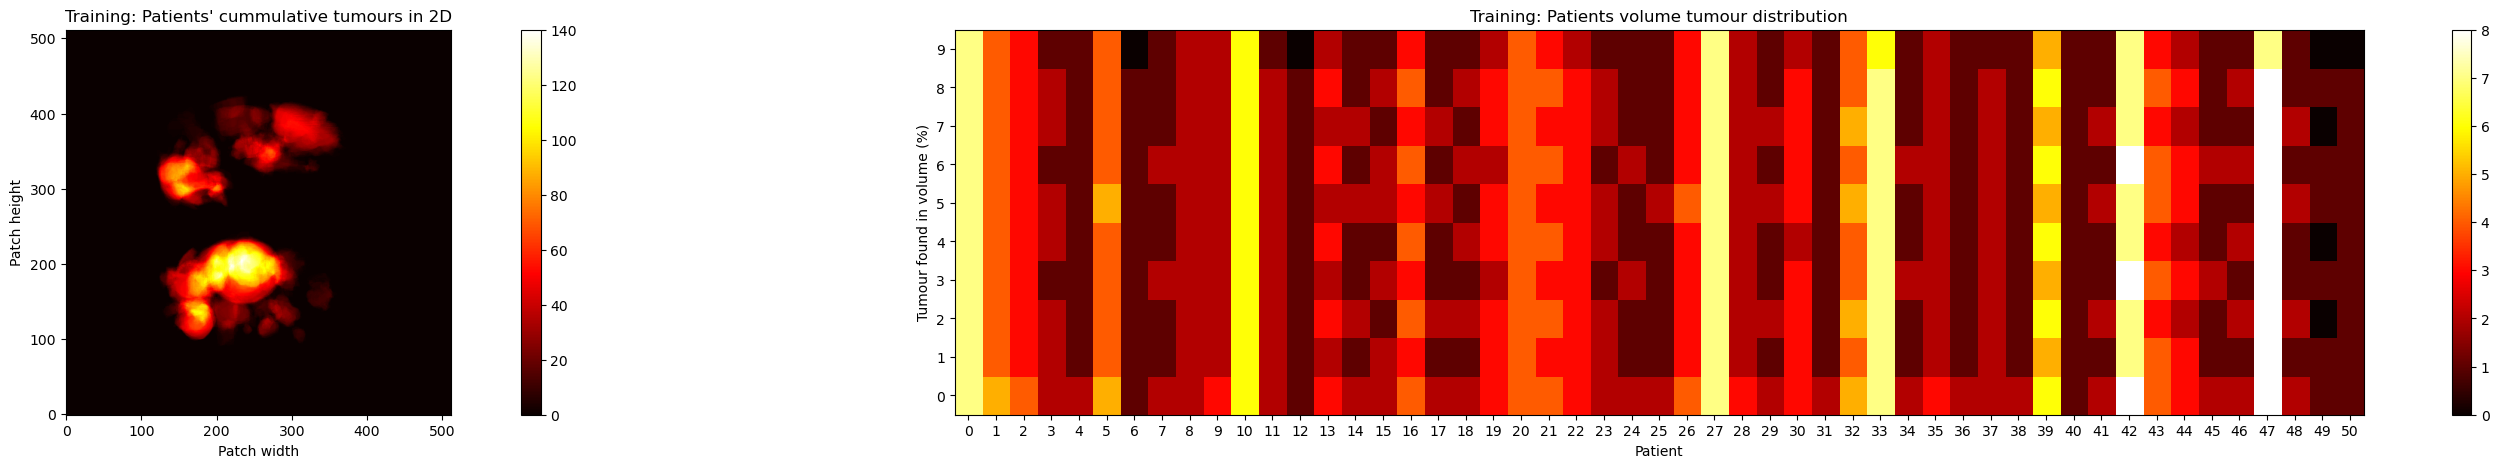

In [27]:
plot_aggregative_heatmaps(bins_2d_tr, binning_volume_tr, train_name)

In [34]:
aggregative_2d_tumor = np.sum(bins_2d_tr, axis=0)
height, width = aggregative_2d_tumor.shape

h_min, h_max = -1, -1
w_min, w_max = -1, -1

for i in range(height):
    if np.sum(aggregative_2d_tumor[i, :]) != 0:
        h_min = i
        break

for i in range(height-1, 0, -1):
    if np.sum(aggregative_2d_tumor[i, :]) != 0:
        h_max = i
        break

for i in range(width):
    if np.sum(aggregative_2d_tumor[:, i]) != 0:
        w_min = i
        break

for i in range(width-1, 0, -1):
    if np.sum(aggregative_2d_tumor[:, i]) != 0:
        w_max = i
        break

print(f'Bounding box for tumor in 2D: (Hmin: {h_min}, Hmax: {h_max}), (Wmin: {w_min}, Wmax: {w_max})')

Bounding box for tumor in 2D: (Hmin: 92, Hmax: 424), (Wmin: 119, Wmax: 371)


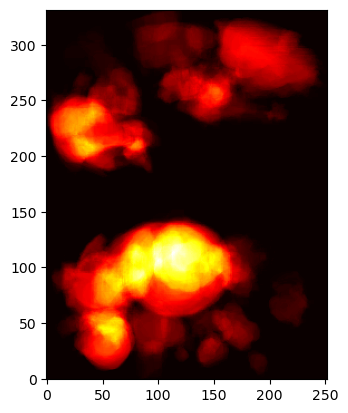

In [32]:
plt.imshow(aggregative_2d_tumor[h_min:h_max, w_min:w_max], cmap='hot')
plt.gca().invert_yaxis()

In [47]:
def plots_tumor_slices_per_patient_split(stacks_full_volume, name, verbose_flag = False):
    NO_PATIENTS = len(stacks_full_volume)

    mean_tumor_stacks = np.mean(stacks_full_volume)
    std_tumor_stacks = np.std(stacks_full_volume)

    print(f'Mean number of tumorous stacks: {mean_tumor_stacks}')
    print(f'Std for the number of tumorous stacks: {std_tumor_stacks}')

    fig, ax = plt.subplots(1,2, figsize=(15, 5))

    # Slices
    ax[0].bar(range(NO_PATIENTS), stacks_full_volume)

    # Add labels on bar chart
    if verbose_flag:
        for i in range(NO_PATIENTS):
            ax[0].text(i, stacks_full_volume[i], str(stacks_full_volume[i]), ha='center')

    # Add the mean as a red line, starting from 0 to NO_PATIENTS
    ax[0].axhline(mean_tumor_stacks, color='red', label='Mean')

    # Add variance as a yellow faded area
    ax[0].fill_between(np.arange(-0.5, NO_PATIENTS+0.5), mean_tumor_stacks - std_tumor_stacks, mean_tumor_stacks + std_tumor_stacks, color='yellow', alpha=0.5, label='Variance')

    ax[0].set_xlim(-1, NO_PATIENTS)
    ax[0].set_xlabel('Patient')
    ax[0].set_ylabel('Number of tumorous stacks in CT')
    ax[0].set_title(f'{name.capitalize()}: Number of tumorous stacks in CT for each patient')
    ax[0].legend()

    # # Slices
    plt.hist(stacks_full_volume, bins=10)

    # Add the mean as a red line
    ax[1].set_xlabel('Number of tumorous stacks in CT')
    ax[1].set_ylabel('Frequency')
    ax[1].set_title(f'{train_name.capitalize()}: Number of tumorous stacks in CT for each patient - Histogram')
    fig.show()
    plt.show()

    return mean_tumor_stacks, std_tumor_stacks


Mean number of tumorous stacks: 26.84313725490196
Std for the number of tumorous stacks: 19.18268474638522


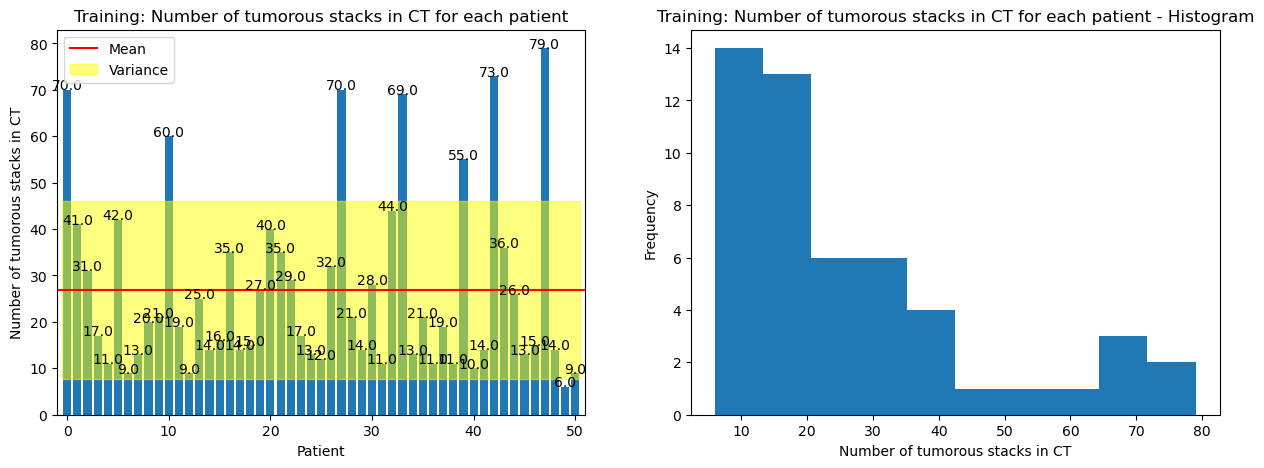

In [39]:
mean_tumor_stacks_tr, std_tumor_stacks_tr = plots_tumor_slices_per_patient_split(np.sum(stacks_full_volume_tr, axis=1), train_name, verbose_flag = True)

In [40]:
import pandas as pd

df = pd.DataFrame(tumor_volume_tr, columns=['Tumor Volume (Voxels)', 'Total Volume (Voxels)'])

# Name index column "Patient"
df.index.name = 'Patient'

df['Tumor Volume (%)'] = df['Tumor Volume (Voxels)'] / df['Total Volume (Voxels)'] * 100

df.to_csv('tumor_volume.csv')

In [341]:
tumor_sizes = np.sum(stacks_full_volume_tr, axis=1)
np.min(tumor_sizes), np.max(tumor_sizes), np.mean(tumor_sizes), np.std(tumor_sizes)

(6.0, 79.0, 26.84313725490196, 19.18268474638522)

## VALIDATION

In [55]:
# Load data
val_name = 'validation' # From Monai: ['training', 'validation', 'test']
val_dataset = DecathlonDataset(root_dir = f'{datasets_path}{val_name}/',
                           task = "Task06_Lung", section = val_name,
                           transform = train_transform, download = False)

val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False) #, num_workers = 1)

Loading dataset: 100%|██████████| 12/12 [00:46<00:00,  3.86s/it]


In [61]:
with open('./tumorous_stacks_train.pkl', 'rb') as f:
    xaxaxa = pkl.load(f)

xaxaxa[0]

[334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 361,
 362,
 363,
 364,
 365,
 366,
 367,
 368,
 369,
 370,
 371,
 372,
 373,
 374,
 375,
 376,
 377,
 378,
 379,
 380,
 381,
 382,
 383,
 384,
 385,
 386,
 387,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 398,
 399,
 400,
 401,
 402,
 403]

In [237]:
NO_PATIENTS_VAL, NO_STACKS_VAL, IMG_HEIGHT_VAL, IMG_WIDTH_VAL = get_EDA_params(val_dataset, val_loader)

Getting EDA parameters...
Number of patients: 12


100%|██████████| 12/12 [00:00<00:00, 16.98it/s]

Number of max-stacks: 493
Image height: 512
Image width: 512


In [343]:
print_slices_flag = False
show_slices(train_loader, print_slices_flag = print_slices_flag)

In [344]:
binning_volume_val, stacks_full_volume_val, bins_2d_val, tumor_volume_val, slices_per_patient_val = update_quantitative_counters(val_dataset, val_loader)

Getting EDA parameters...
Number of patients: 12


100%|██████████| 12/12 [00:00<00:00, 15.86it/s]


Number of max-stacks: 493
Image height: 512
Image width: 512
2D bins shape: (12, 32, 32) (NO_PATIENTS, NO_PATCHES_HEIGHT, NO_PATCHES_WIDTH)
Depth bins shape: (12, 10) (NO_PATIENTS, PERCENTAGE_BINS)


100%|██████████| 12/12 [00:40<00:00,  3.34s/it]


Mean number of slices: 271.1666666666667
Std for the number of slices: 99.81218473824838


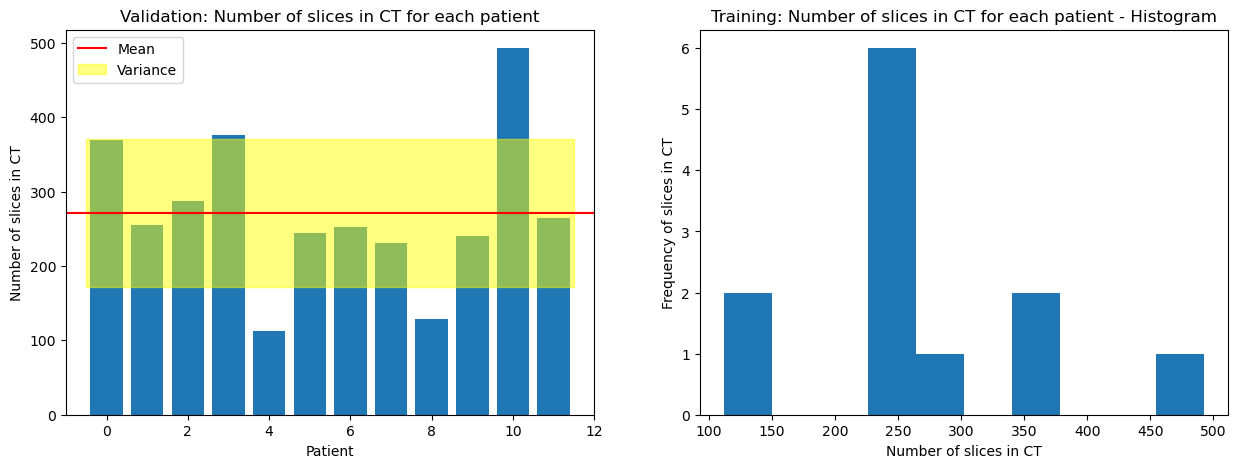

In [345]:
plots_slices_per_patient_split(slices_per_patient_val, val_name)

In [346]:
plot_patients_heatmaps(bins_2d_val, val_name, print_slices_flag = False)

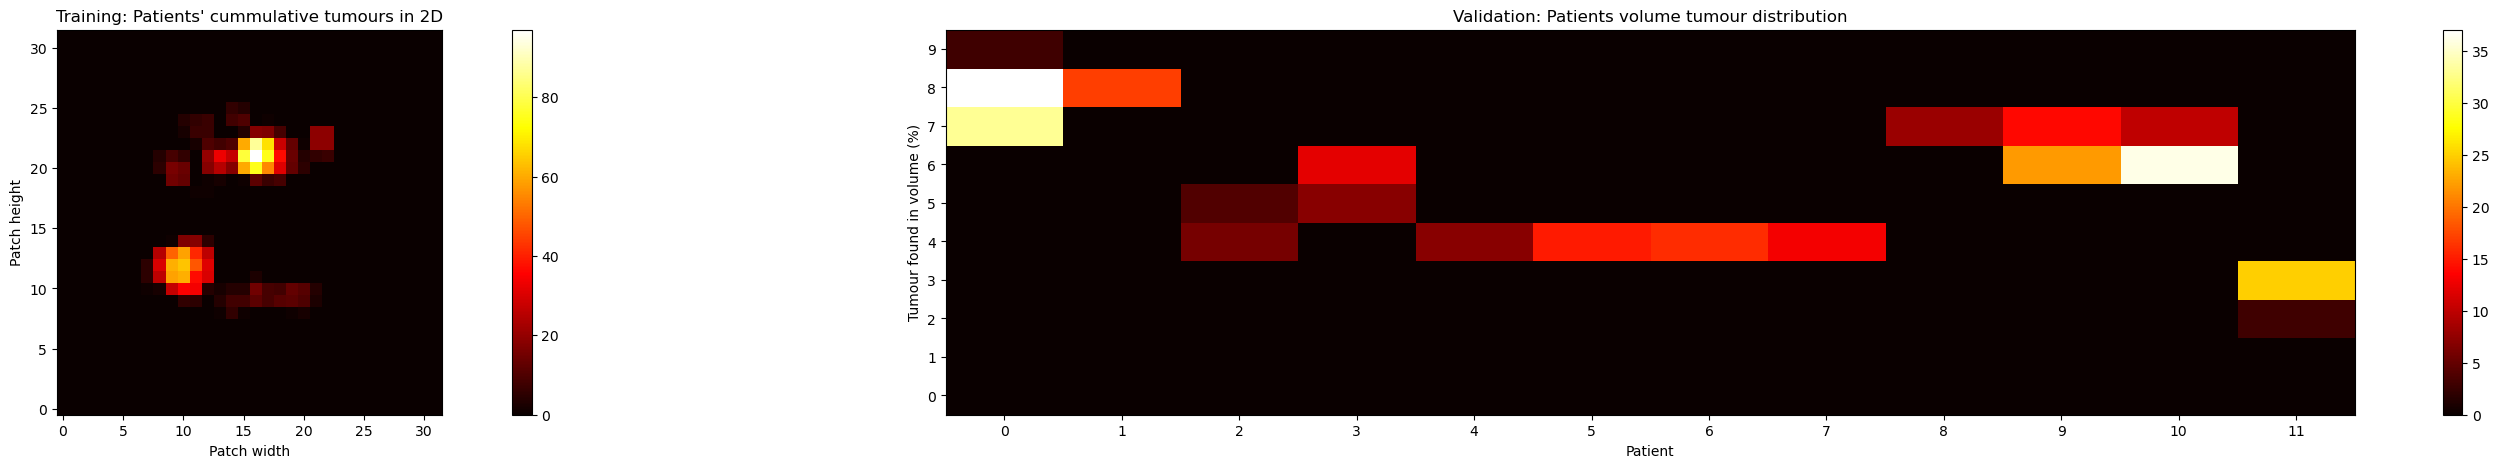

In [347]:
plot_aggregative_heatmaps(bins_2d_val, binning_volume_val, val_name)

Mean number of tumorous stacks: 24.0
Std for the number of tumorous stacks: 18.54274341442855


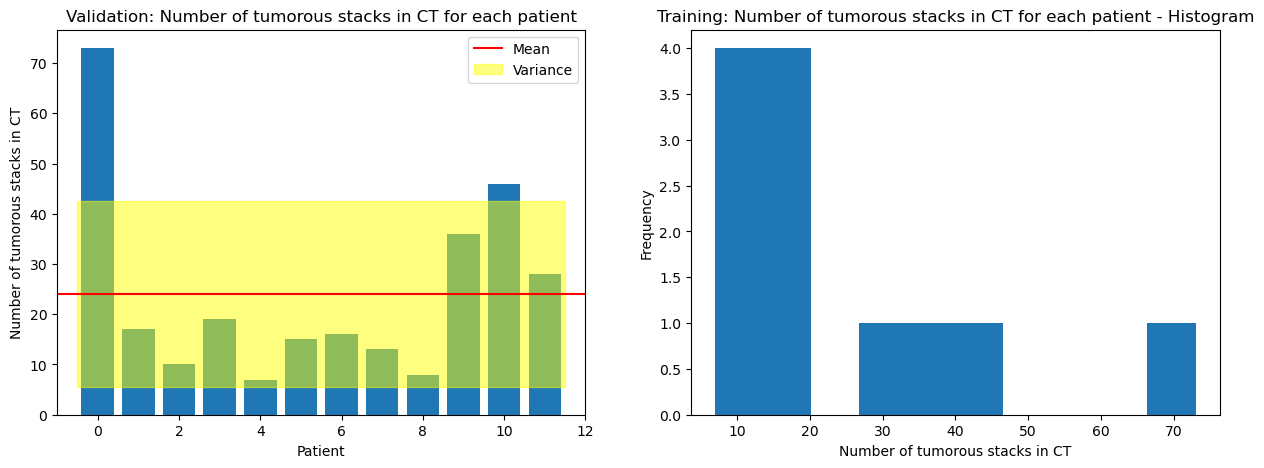

In [365]:
mean_tumor_stacks_val, std_tumor_stacks_val = plots_tumor_slices_per_patient_split(np.sum(stacks_full_volume_val, axis=1), val_name)

In [349]:
tumor_sizes_val = np.sum(stacks_full_volume_val, axis=1)
np.min(tumor_sizes_val), np.max(tumor_sizes_val), np.mean(tumor_sizes_val), np.std(tumor_sizes_val)

(7.0, 73.0, 24.0, 18.54274341442855)

In [366]:
tumor_sizes_filtered = np.array([x for x in tumor_sizes_val if x >= mean_tumor_stacks_val - std_tumor_stacks_val and x <= mean_tumor_stacks_val + std_tumor_stacks_val])
len(tumor_sizes_filtered)

10

Mean number of tumorous stacks: 15.5
Std for the number of tumorous stacks: 0.5


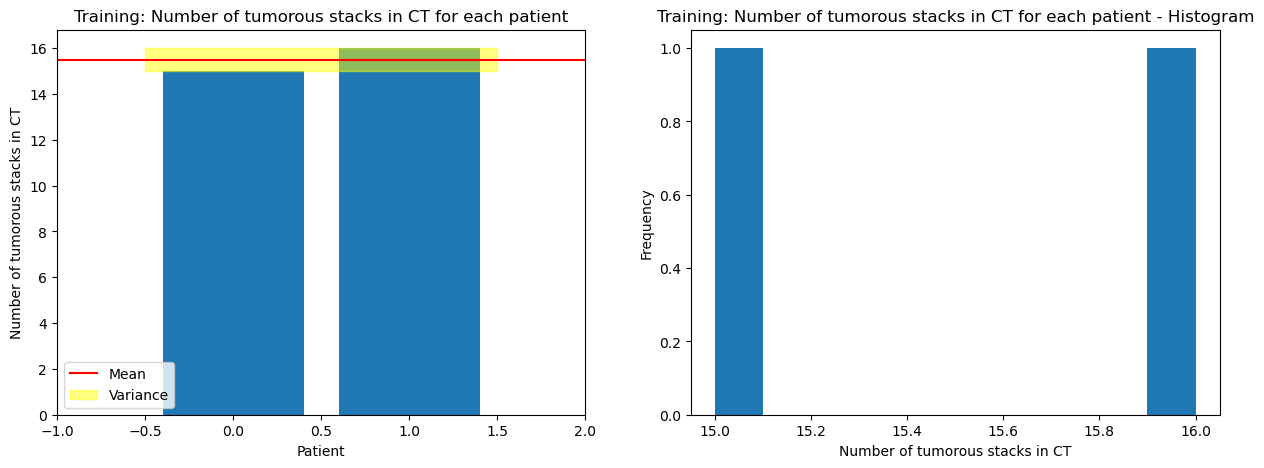

In [375]:
mean_tumor_stacks_tr2, std_tumor_stacks_tr2 = plots_tumor_slices_per_patient_split(tumor_sizes_filtered, train_name)
tumor_sizes_filtered = np.array([x for x in tumor_sizes_filtered if x >= mean_tumor_stacks_tr2 - std_tumor_stacks_tr2 and x <= mean_tumor_stacks_tr2 + std_tumor_stacks_tr2])